## Graph Neural Networks

We now use Tensorflow to classify nodes in a graph using Graph Convolution Networks.

First, install gcn on your machine using the 'python setup.py install' command.

# Exercise for semisupervised classification on citation networks

In [1]:
from __future__ import division
from __future__ import print_function

import time
import tensorflow as tf
from gcn.utils import *
from gcn.models import Model,MLP
from gcn.layers import *

In [2]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('dataset_2', 'citeseer', 'Dataset_2 string.')  # 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'dense'
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
#flags.DEFINE_float('learning_rate', 0.1, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
#flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
#flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 100, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')

In [3]:
def masked_softmax_cross_entropy(preds, labels, mask):
    """Softmax cross-entropy loss with masking."""
    loss = tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_mean_square_error(preds,labels,mask):
    """ L-2 loss """
    loss = tf.nn.l2_loss(preds - labels)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    loss *= mask
    return tf.reduce_mean(loss)

def masked_accuracy(preds, labels, mask):
    """Accuracy with masking."""
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    accuracy_all = tf.cast(correct_prediction, tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    mask /= tf.reduce_mean(mask)
    accuracy_all *= mask
    return tf.reduce_mean(accuracy_all)

In [4]:
class GCN(Model):
    def __init__(self, placeholders, input_dim, **kwargs):
        super(GCN, self).__init__(**kwargs)

        self.inputs = placeholders['features']
        self.input_dim = input_dim
        # self.input_dim = self.inputs.get_shape().as_list()[1]  # To be supported in future Tensorflow versions
        self.output_dim = placeholders['labels'].get_shape().as_list()[1]
        self.placeholders = placeholders

        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)

        self.build()

    def _loss(self):
        # Weight decay loss
        for var in self.layers[0].vars.values():
            self.loss += FLAGS.weight_decay * tf.nn.l2_loss(var)

        # Cross entropy error
        self.loss += masked_mean_square_error(self.outputs, self.placeholders['labels'],
                                              self.placeholders['labels_mask'])
        # self.loss += masked_softmax_cross_entropy(self.outputs, self.placeholders['labels'],
        #                                           self.placeholders['labels_mask'])

    def _accuracy(self):
        self.accuracy = masked_accuracy(self.outputs, self.placeholders['labels'],
                                        self.placeholders['labels_mask'])

    def _build(self):

        self.layers.append(GraphConvolution(input_dim=self.input_dim,
                                            output_dim=FLAGS.hidden1,
                                            placeholders=self.placeholders,
                                            act=tf.nn.relu,
                                            dropout=True,
                                            sparse_inputs=True,
                                            logging=self.logging))

        self.layers.append(GraphConvolution(input_dim=FLAGS.hidden1,
                                            output_dim=self.output_dim,
                                            placeholders=self.placeholders,
                                            act=lambda x: x,
                                            dropout=True,
                                            logging=self.logging))

    def predict(self):
        return tf.nn.softmax(self.outputs)

In [5]:
def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return sparse_to_tuple(adj_normalized)
#    adj_square = np.power(adj,2).tocoo()
#    return sparse_to_tuple(adj)


In [6]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

In [7]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 70.30534 train_acc= 0.07143 val_loss= 248.96060 val_acc= 0.18400 time= 0.04883
Epoch: 0002 train_loss= 69.51312 train_acc= 0.28571 val_loss= 247.73361 val_acc= 0.29600 time= 0.01511
Epoch: 0003 train_loss= 69.11311 train_acc= 0.45714 val_loss= 246.32149 val_acc= 0.40200 time= 0.01950
Epoch: 0004 train_loss= 68.73877 train_acc= 0.57857 val_loss= 244.89812 val_acc= 0.47600 time= 0.01779
Epoch: 0005 train_loss= 67.98429 train_acc= 0.69286 val_loss= 243.58395 val_acc= 0.52400 time= 0.02154
Epoch: 0006 train_loss= 67.54814 train_acc= 0.73571 val_loss= 242.55818 val_acc= 0.55200 time= 0.02131
Epoch: 0007 train_loss= 67.09998 train_acc= 0.80714 val_loss= 241.80969 val_acc= 0.59600 time= 0.01913
Epoch: 0008 train_loss= 66.38895 train_acc= 0.79286 val_loss= 241.22533 val_acc= 0.63000 time= 0.01874
Epoch: 0009 train_loss= 65.86577 train_acc= 0.87143 val_loss= 240.75558 val_acc= 0.68000 time= 0.01603
Epoch: 0010 train_loss= 65.51508 train_acc= 0.86429 val_loss= 240.41539 v

Epoch: 0084 train_loss= 54.26834 train_acc= 0.97857 val_loss= 247.55428 val_acc= 0.46200 time= 0.01421
Epoch: 0085 train_loss= 53.28731 train_acc= 0.97143 val_loss= 247.62164 val_acc= 0.46000 time= 0.01544
Epoch: 0086 train_loss= 53.82362 train_acc= 0.97143 val_loss= 247.66472 val_acc= 0.46000 time= 0.01731
Epoch: 0087 train_loss= 54.12738 train_acc= 0.96429 val_loss= 247.69556 val_acc= 0.46000 time= 0.01674
Epoch: 0088 train_loss= 54.02099 train_acc= 0.97143 val_loss= 247.73383 val_acc= 0.45600 time= 0.01282
Epoch: 0089 train_loss= 54.42538 train_acc= 0.97143 val_loss= 247.80040 val_acc= 0.45800 time= 0.01318
Epoch: 0090 train_loss= 54.70245 train_acc= 0.96429 val_loss= 247.91379 val_acc= 0.46000 time= 0.01427
Epoch: 0091 train_loss= 54.62503 train_acc= 0.96429 val_loss= 248.02254 val_acc= 0.46000 time= 0.01331
Epoch: 0092 train_loss= 54.10172 train_acc= 0.97143 val_loss= 248.16452 val_acc= 0.46000 time= 0.01268
Epoch: 0093 train_loss= 52.92982 train_acc= 0.97857 val_loss= 248.31393 v

In [8]:
# Testing
test_cost, test_acc, test_duration = evaluate(features, support, y_test, test_mask, placeholders)
print("Test set results:", "cost=", "{:.5f}".format(test_cost),
      "accuracy=", "{:.5f}".format(test_acc), "time=", "{:.5f}".format(test_duration))

Test set results: cost= 480.59225 accuracy= 0.47400 time= 0.00769


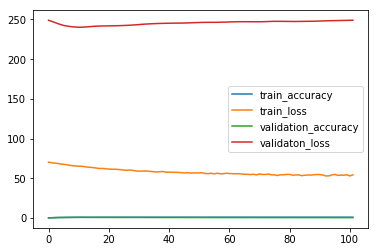

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.show()

# 1. With no weight dacy / dropout  (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **without weight decay and without dropout**.

# 2. Change it to $A^2$ (covered in class)

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **after changing the adjacency matrix to $A^2$ **.

# 3. Change to the $L_2$ loss

Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps **with the loss function being $L_2$ loss**.

In [10]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 70.17213 train_acc= 0.07857 val_loss= 247.88293 val_acc= 0.19400 time= 0.01548
Epoch: 0002 train_loss= 69.43874 train_acc= 0.22857 val_loss= 246.43976 val_acc= 0.27800 time= 0.01354
Epoch: 0003 train_loss= 68.87204 train_acc= 0.42143 val_loss= 245.13405 val_acc= 0.42800 time= 0.01274
Epoch: 0004 train_loss= 68.31245 train_acc= 0.56429 val_loss= 243.97650 val_acc= 0.53800 time= 0.01278
Epoch: 0005 train_loss= 67.78450 train_acc= 0.63571 val_loss= 242.99306 val_acc= 0.61000 time= 0.01281
Epoch: 0006 train_loss= 67.33092 train_acc= 0.70000 val_loss= 242.26442 val_acc= 0.62400 time= 0.01414
Epoch: 0007 train_loss= 66.69719 train_acc= 0.80714 val_loss= 241.85512 val_acc= 0.63200 time= 0.01449
Epoch: 0008 train_loss= 66.63135 train_acc= 0.81429 val_loss= 241.62746 val_acc= 0.63000 time= 0.01391
Epoch: 0009 train_loss= 66.28365 train_acc= 0.77857 val_loss= 241.45602 val_acc= 0.63600 time= 0.01290
Epoch: 0010 train_loss= 65.58755 train_acc= 0.82143 val_loss= 241.26761 v

Epoch: 0087 train_loss= 54.02000 train_acc= 0.98571 val_loss= 248.14159 val_acc= 0.45600 time= 0.01438
Epoch: 0088 train_loss= 54.35558 train_acc= 0.97143 val_loss= 248.19489 val_acc= 0.46000 time= 0.01587
Epoch: 0089 train_loss= 54.57681 train_acc= 0.97143 val_loss= 248.27771 val_acc= 0.46000 time= 0.01615
Epoch: 0090 train_loss= 53.99089 train_acc= 0.97857 val_loss= 248.37361 val_acc= 0.45400 time= 0.01764
Epoch: 0091 train_loss= 53.94865 train_acc= 0.97143 val_loss= 248.46854 val_acc= 0.45200 time= 0.01325
Epoch: 0092 train_loss= 53.32748 train_acc= 0.99286 val_loss= 248.55003 val_acc= 0.45200 time= 0.01288
Epoch: 0093 train_loss= 53.39418 train_acc= 0.99286 val_loss= 248.60071 val_acc= 0.44600 time= 0.01263
Epoch: 0094 train_loss= 53.73022 train_acc= 0.96429 val_loss= 248.60922 val_acc= 0.44800 time= 0.01238
Epoch: 0095 train_loss= 54.00950 train_acc= 0.97143 val_loss= 248.55411 val_acc= 0.44600 time= 0.01229
Epoch: 0096 train_loss= 53.16956 train_acc= 0.97143 val_loss= 248.49576 v

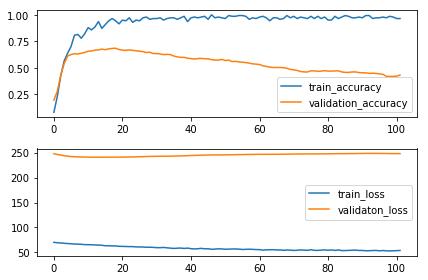

In [11]:
import matplotlib.pyplot as plt

p1 = plt.subplot(211)
p2 = plt.subplot(212)

p1.plot(train_accuracy,label = 'train_accuracy')
p1.plot(validation_accuracy, label='validation_accuracy')
p1.legend()

p2.plot(train_loss,label = 'train_loss')
p2.plot(validation_loss,label='validaton_loss')
p2.legend()

plt.tight_layout()
plt.show()

# 4. Change the input graph/label

Now, create the input graphs using a Stochastic Block Model. The number of nodes should be 500, and then feed the true labels using $20%$ of the nodes. The degree of a node must be used as the feature.
Make a plot of training accuracy, training loss, validation accuracy and validation loss against the number of steps for this input graph.

In [12]:
import networkx as nx
import random

def is_sameCluster(N, i, j):
    if ((i <= (N+1)/2) and (j <= (N+1)/2)) or ((i > (N+1)/2) and (j > (N+1)/2)):
        return True
    else:
        return False

def addEdge(G, prob, i, j):
    temp = random.uniform(0, 1)
    if temp < prob:
        G.add_edge(i, j)        
        
def generateGraph(N, alpha):
    G = nx.Graph()
    G.add_nodes_from(range(1, N+1))
    nodes = G.nodes()
    for i in nodes:
        for j in nodes:
            if is_sameCluster(N, i, j):
                prob = 0.5 + alpha
            else:
                prob = 0.5 - alpha
            addEdge(G, prob, i, j)
            
    for (i,j) in G.edges():
        G[i][j]['d'] = len(set(G.neighbors(i)).intersection(set(G.neighbors(j))))
        
    return G

In [13]:
G = generateGraph(500, 0.3)
adjacency = nx.adjacency_matrix(G).todense()
print(adjacency.shape)

(500, 500)


In [14]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset_2)

# Some preprocessing
features = preprocess_features(features)
if FLAGS.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif FLAGS.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, FLAGS.max_degree)
    num_supports = 1 + FLAGS.max_degree
    model_func = GCN
elif FLAGS.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(FLAGS.model))

# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

# Create model
model = model_func(placeholders, input_dim=features[2][1], logging=True)

# Initialize session
sess = tf.Session()


# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

/Users/rahulswamy/Dropbox/ie532/submissions/ex5/gcn/utils.py:97: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


In [15]:
# Initialize weights
sess.run(tf.global_variables_initializer())

train_loss = []
validation_loss = []
train_accuracy = []
validation_accuracy = []


# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
    
    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    validation_loss.append(cost)
    validation_accuracy.append(acc)
    train_loss.append(outs[1])
    train_accuracy.append(outs[2])

    # Print results
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
          "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
          "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and validation_loss[-1] > np.mean(validation_loss[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break

print("Optimization Finished!")

Epoch: 0001 train_loss= 60.03241 train_acc= 0.22500 val_loss= 247.41069 val_acc= 0.41000 time= 0.05145
Epoch: 0002 train_loss= 59.44440 train_acc= 0.43333 val_loss= 246.29999 val_acc= 0.54600 time= 0.02681
Epoch: 0003 train_loss= 58.90879 train_acc= 0.51667 val_loss= 245.75726 val_acc= 0.60400 time= 0.02575
Epoch: 0004 train_loss= 58.44637 train_acc= 0.72500 val_loss= 245.53174 val_acc= 0.62200 time= 0.02592
Epoch: 0005 train_loss= 57.84655 train_acc= 0.77500 val_loss= 245.36873 val_acc= 0.63000 time= 0.02544
Epoch: 0006 train_loss= 57.36644 train_acc= 0.78333 val_loss= 245.18605 val_acc= 0.62600 time= 0.02600
Epoch: 0007 train_loss= 56.67850 train_acc= 0.87500 val_loss= 244.96838 val_acc= 0.60600 time= 0.02512
Epoch: 0008 train_loss= 56.24786 train_acc= 0.88333 val_loss= 244.75908 val_acc= 0.59000 time= 0.02640
Epoch: 0009 train_loss= 55.70902 train_acc= 0.89167 val_loss= 244.63945 val_acc= 0.59600 time= 0.02669
Epoch: 0010 train_loss= 55.02552 train_acc= 0.89167 val_loss= 244.57333 v

Epoch: 0086 train_loss= 41.16063 train_acc= 0.97500 val_loss= 256.22589 val_acc= 0.25600 time= 0.02574
Epoch: 0087 train_loss= 40.18763 train_acc= 0.97500 val_loss= 256.33493 val_acc= 0.25800 time= 0.02605
Epoch: 0088 train_loss= 40.97846 train_acc= 0.96667 val_loss= 256.49341 val_acc= 0.25800 time= 0.02682
Epoch: 0089 train_loss= 41.22199 train_acc= 0.97500 val_loss= 256.63733 val_acc= 0.26000 time= 0.02596
Epoch: 0090 train_loss= 40.52702 train_acc= 0.98333 val_loss= 256.78549 val_acc= 0.25600 time= 0.02591
Epoch: 0091 train_loss= 40.36060 train_acc= 0.97500 val_loss= 256.87115 val_acc= 0.25600 time= 0.02585
Epoch: 0092 train_loss= 41.18401 train_acc= 0.95000 val_loss= 256.87802 val_acc= 0.25400 time= 0.02628
Epoch: 0093 train_loss= 41.08439 train_acc= 0.97500 val_loss= 256.87320 val_acc= 0.25400 time= 0.02564
Epoch: 0094 train_loss= 40.76528 train_acc= 0.99167 val_loss= 256.88217 val_acc= 0.25200 time= 0.02546
Epoch: 0095 train_loss= 41.12056 train_acc= 0.99167 val_loss= 256.85782 v

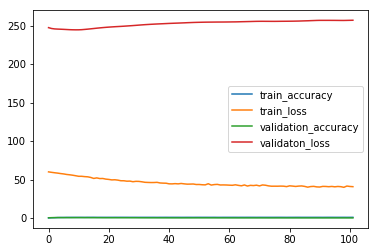

In [16]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_accuracy,label = 'train_accuracy')
plt.plot(train_loss,label = 'train_loss')
plt.plot(validation_accuracy, label='validation_accuracy')
plt.plot(validation_loss,label='validaton_loss')
plt.legend()
plt.show()